#### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
from tqdm import tqdm
from skimage.external import tifffile as sktif

import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from joblib import Parallel, delayed
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

In [3]:
import solaris as sol
import skimage
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.ops import cascaded_union

W0828 21:41:43.957248 140031312136000 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/metrics.py:103: The name tf.keras.metrics.cosine_proximity is deprecated. Please use tf.keras.losses.cosine_similarity instead.

W0828 21:41:43.983619 140031312136000 deprecation_wrapper.py:119] From /home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/solaris/nets/_keras_losses.py:104: The name tf.keras.losses.cosine is deprecated. Please use tf.keras.losses.cosine_similarity instead.



#### Setup

In [4]:
from lovasz_losses import *
def accuracy_pixel(input, target):
    target = target.squeeze(1)
    mask = (target != 0)
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [5]:
data_dir = Path("/media/wwymak/Storage/spacenet_roads")
train_dir = data_dir / "AOI_3_Paris_Roads_Train"
# small image/mask tiles made in space_net_roads_nvidia.ipynb
rgb_256 = train_dir / "rgb_256"

mask_256 = train_dir / "mask_256"

[PosixPath('/media/wwymak/Storage/spacenet_roads/AOI_3_Paris_Roads_Train/mask_256/mask_256_AOI_3_Paris_img111_1_4.png')]


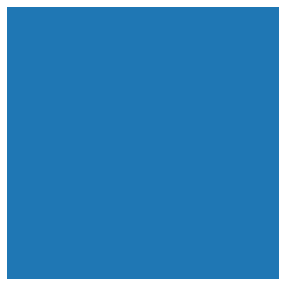

In [8]:
fname = np.random.choice(mask_256.ls(), 1)
print(fname)
mask = open_mask(fname[0])
mask.show(figsize=(5,5), alpha=1)

In [9]:
mask_with_roads_256 = train_dir / "mask_with_roads_256"
mask_with_roads_256.mkdir(exist_ok=True)

In [27]:
def cp_mask_with_roads(fpath):
    with PIL.Image.open(fpath) as test_image:
        a = np.array(test_image)
        if (a.max() >=1):
            test_image.save(mask_with_roads_256/fpath.name)

In [28]:

%time out = Parallel(n_jobs=28)(delayed(cp_mask_with_roads)(fpath) for fpath in mask_256.ls());

CPU times: user 1.35 s, sys: 214 ms, total: 1.57 s
Wall time: 3.96 s


In [7]:
len(mask_with_roads_256.ls())

3420

In [10]:
mask_ids = [f.name for f in mask_with_roads_256.ls()]
mask_ids[:5]

['mask_256_AOI_3_Paris_img310_1_1.png',
 'mask_256_AOI_3_Paris_img55_4_3.png',
 'mask_256_AOI_3_Paris_img235_3_1.png',
 'mask_256_AOI_3_Paris_img153_2_3.png',
 'mask_256_AOI_3_Paris_img295_4_3.png']

In [11]:
valid_imgs = [f.replace('mask', 'rgb').replace('png', 'tif') for f in mask_ids]

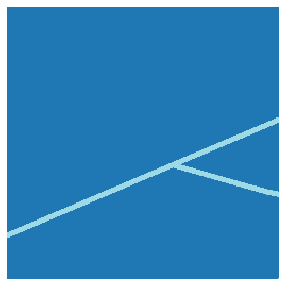

In [12]:
fname = np.random.choice(mask_with_roads_256.ls(), 1)

mask = open_mask(fname[0])
mask.show(figsize=(5,5), alpha=1)

In [13]:
class dice_bce_loss(nn.Module):
    # from dlink net paper
    def __init__(self, batch=True):
        super().__init__()
        self.batch = batch
        self.bce_loss = nn.BCELoss()
        
    def soft_dice_coeff(self, y_pred, y_true):
        print(y_true.shape, y_pred.shape)
        smooth = 0.0  # may change
        if self.batch:
            i = torch.sum(y_true)
            j = torch.sum(y_pred)
            intersection = torch.sum(y_true * y_pred)
        else:
            i = y_true.sum(1).sum(1).sum(1)
            j = y_pred.sum(1).sum(1).sum(1)
            intersection = (y_true * y_pred).sum(1).sum(1).sum(1)
        score = (2. * intersection + smooth) / (i + j + smooth)
        #score = (intersection + smooth) / (i + j - intersection + smooth)#iou
        return score.mean()

    def soft_dice_loss(self,y_pred, y_true):
        loss = 1 - self.soft_dice_coeff(y_true, y_pred)
        return loss
        
    def __call__(self, y_pred, y_true ):
        preds = y_pred.argmax(dim=1).float()
        truth = y_true.squeeze(1).float()
        print(preds.shape, truth.shape, 'here')
        a =  self.bce_loss(preds, truth)
        b =  self.soft_dice_loss(preds, truth)
        return a + b

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        # Inspired by the implementation of binary_cross_entropy_with_logits
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()

        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
        invprobs = F.logsigmoid(-input * (target * 2 - 1))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [14]:

def get_mask_fn(fname):
    return mask_with_roads_256 / fname.name.replace("rgb", "mask").replace("tif", "png")

# def get_mask_fn(fname):
#     return mask_256 / fname.name.replace("rgb", "mask").replace("tif", "png")

codes = np.array(["void", "road"])

src = (SegmentationItemList.from_folder(rgb_256)
       .filter_by_func(lambda x: Path(x).name in valid_imgs)
       .split_by_rand_pct(0.2, seed=42)
       .label_from_func(get_mask_fn, classes=codes)
      )

bs = 16
size=256

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

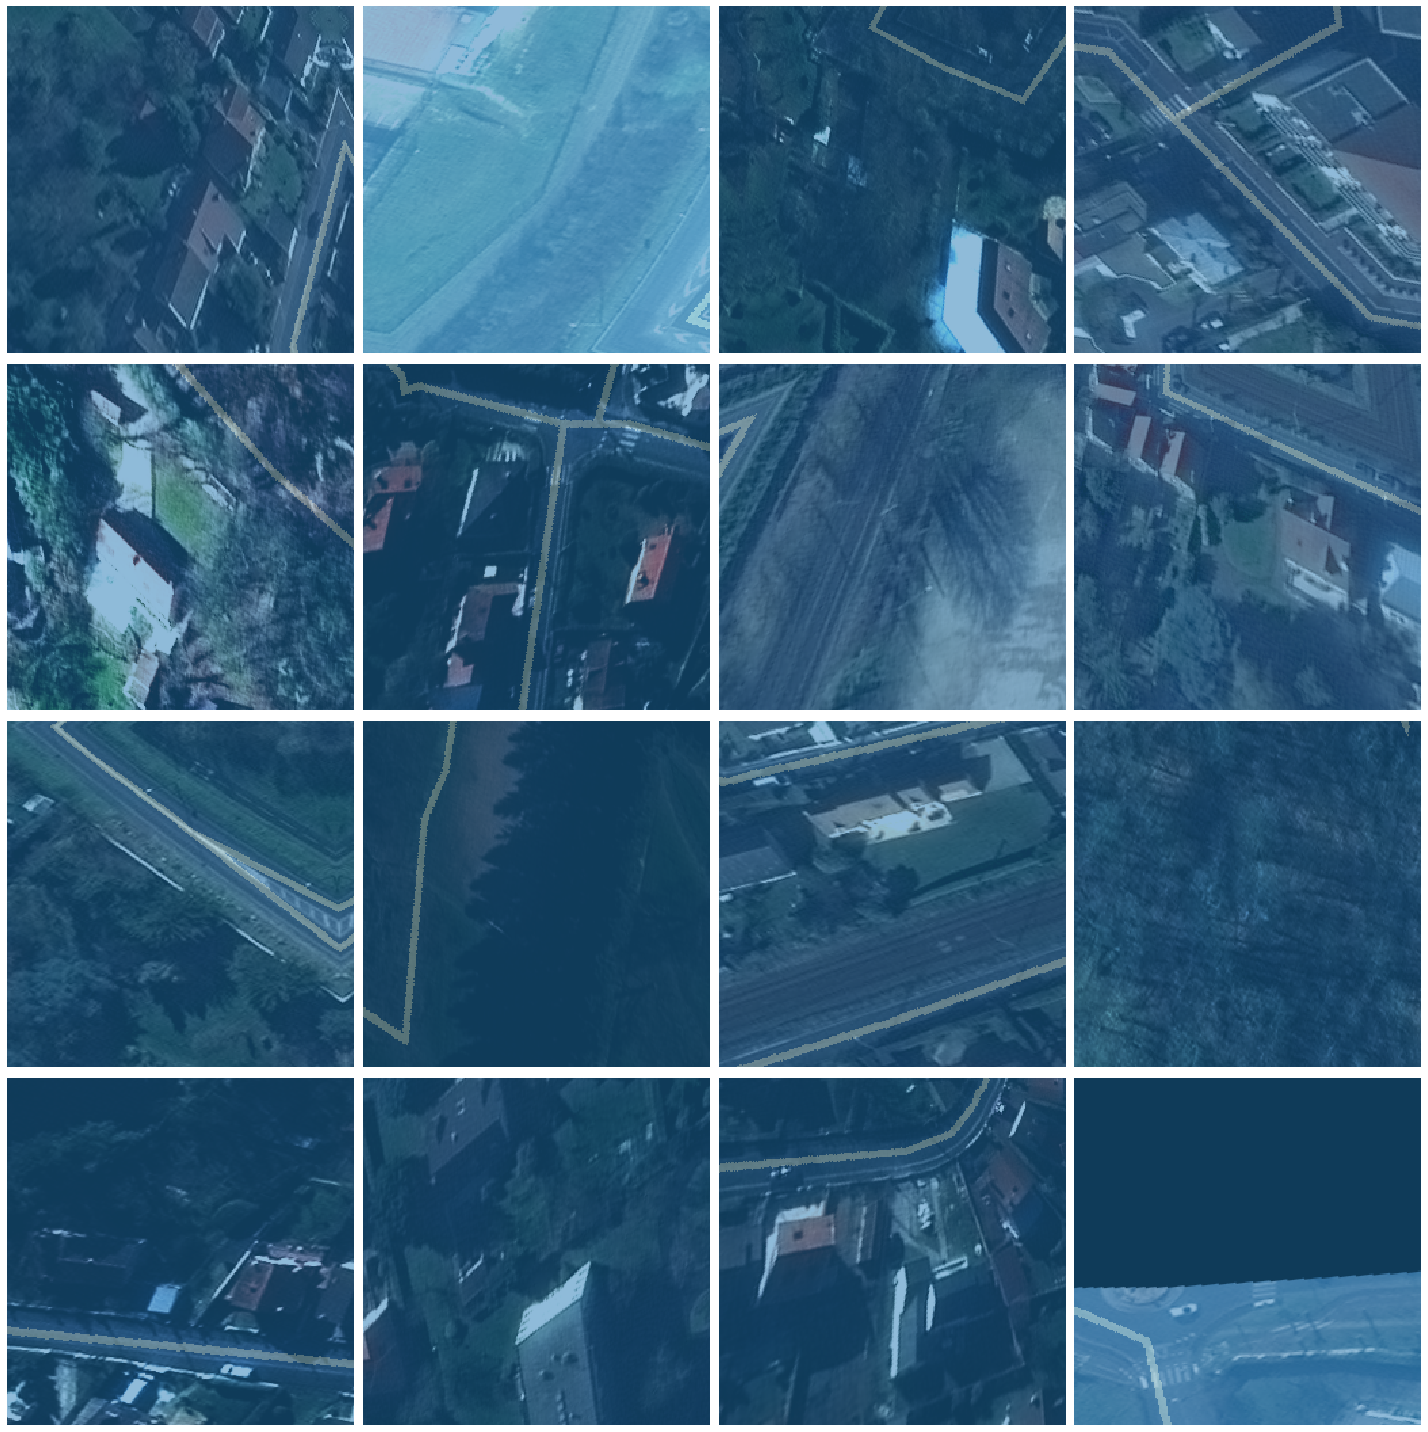

In [15]:
data.show_batch(8, figsize=(20,20))

In [15]:
def flatten_binary_scores2(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.contiguous().view(-1)
    labels = labels.contiguous().view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels
def combined_loss(logits, labels):
    logits = logits[:, 1, :, :].float()
    labels = labels.squeeze(1).float()

    lh_loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels))
    bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
#     focal_loss = F.binary_cross_entropy_with_logits(logits, labels)
    return 0.8 * bce_loss + lh_loss
#     return 0.8 * focal_loss + lh_loss

def combined_loss2(logits, labels):
    logits = logits[:, 1, :, :].float()
    labels = labels.squeeze(1).float()

#     lh_loss = lovasz_hinge_flat(*flatten_binary_scores2(logits, labels))
#     bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
    floss = focal_loss(logits, labels)
    dice = dice_loss(logits, labels)
#     print((- dice(logits, labels)).max())
#     print(floss.max())
   
    return 0.2 * dice + 0.8 *floss

def focal_loss(logits, labels):
    alpha = 1
    gamma = 2.
    
    BCE_loss = F.binary_cross_entropy_with_logits(logits, labels, reduction='none')
    pt = torch.exp(-BCE_loss) # prevents nans when probability 0
    F_loss = alpha * (1-pt)**gamma * BCE_loss
    return F_loss#.mean()
    
    
    p = logits.sigmoid()
    pt = p*labels + (1-p)*(1-labels)

    w = alpha*labels + (1-alpha)*(1-labels)
    loss = w * (1-pt).pow(gamma)

    return loss
#     p_t = F.binary_cross_entropy_with_logits(logits, labels)
#     return -alpha * (1- p_t)
# #      FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
#     return F.binary_cross_entropy_with_logits()

def dice_loss(logits, labels):
#     logits = input[:, 1, :, :].float()
#     labels = target.squeeze(1).float()

    smooth = 1.

    iflat = logits.contiguous().view(-1)
    tflat = labels.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))


In [16]:
from dlinknet import DinkNet34

In [36]:
class StableBCELoss(nn.Module):
    def forward(self, input, target):
        neg_abs = - input.abs()
        loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
        return loss.mean()
def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
#     print(logits.max())
    logits = logits.float()
    labels = labels.float()
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss

wd =1e-2
metrics = [partial(foreground_acc, void_code=0),partial(dice, iou=True)]
learn = Learner(data,  DinkNet34(), opt_func=torch.optim.AdamW ,metrics=metrics, loss_func=binary_xloss, wd=wd)

In [18]:
learn.summary()

/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


DinkNet34
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
____________________________________________________

tensor(0.6337, device='cuda:0', grad_fn=<MaxBackward1>)


/home/wwymak/anaconda3/envs/solaris2/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.6584, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6534, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6270, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6220, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6163, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6401, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6206, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6473, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6511, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6158, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6166, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6359, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6337, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6233, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6363, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6276, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6272, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.6390, device='cuda:0', grad_fn=<MaxBack

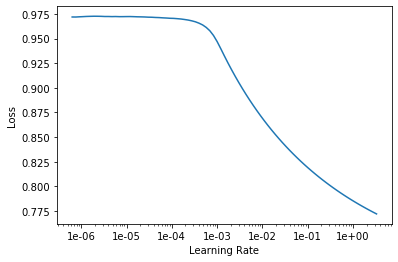

In [35]:

learn.lr_find()
learn.recorder.plot()

In [37]:
lr=1e-2
learn.fit_one_cycle(5, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.695463,0.693147,0.000000,0.000000,00:29
1,0.693220,0.693147,0.000000,0.000000,00:24


KeyboardInterrupt: 

In [80]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,dice,time
0,0.234771,0.234731,0.402979,0.018909,00:14
1,0.234538,0.233781,0.389237,0.024803,00:14
2,0.234481,0.234777,0.391677,0.017361,00:14
3,0.234737,0.234635,0.481133,0.019818,00:14
4,0.234960,0.235146,0.550588,0.021278,00:14
5,0.235054,0.235318,0.546394,0.021094,00:15
6,0.235116,0.235163,0.563624,0.022122,00:15
7,0.234880,0.234383,0.628316,0.029311,00:15
8,0.234784,0.234441,0.766530,0.023380,00:14
9,0.234110,0.233998,0.768406,0.023936,00:15


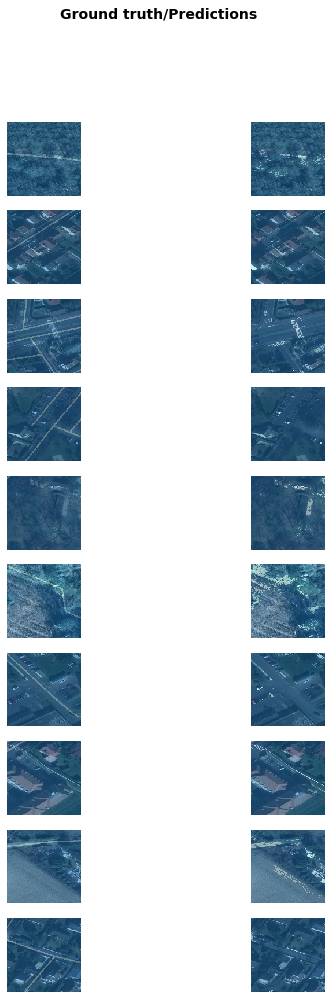

In [18]:
learn.show_results(rows=10, figsize=(8,16))

In [19]:
preds = learn.pred_batch()

In [21]:
preds.shape

torch.Size([16, 2, 128, 128])

In [23]:
predicted_masks = preds.argmax(dim=1).numpy()

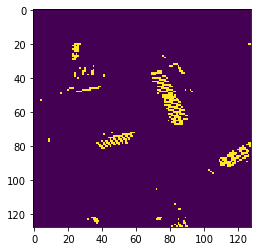

In [26]:
plt.imshow(predicted_masks[2])

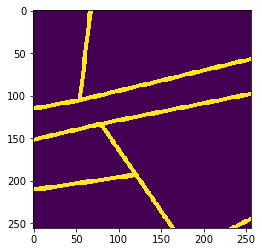

In [34]:
plt.imshow(skimage.io.imread(str(data.valid_ds.y.items[2])))

In [ ]:
skimage.io.